In [4]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle
from sklearn.preprocessing import LabelEncoder

## Data Loading and Oversampling

In [50]:
data = pd.read_csv('preprocessed.csv', index_col=0)
data.head(5)

,merchant,category,amt,gender,street,city,zip,city_pop,job,merch_lat,merch_long,hour,age,is_fraud
0,1.519014,1.615782,-0.407826,-0.909206,-0.207491,-0.232599,-0.209999,-0.282589,-0.316898,-0.494354,0.593864,-1.878145,-0.872823,0
1,0.900957,1.548622,0.230039,-0.909206,-0.207491,-0.232599,-0.209999,-0.293670,-0.281569,2.078699,-2.030341,-1.878145,-0.314203,0
2,-0.667123,-0.616973,0.934149,1.099861,-0.207491,-0.232599,-0.209999,-0.280406,0.744516,0.902849,-1.592323,-1.878145,0.629736,0
3,-0.426116,-0.204031,-0.158132,1.099861,1.005067,1.135357,1.018859,-0.287742,0.155359,1.662886,-1.621848,-1.878145,0.343422,0
4,-0.367463,-0.493928,-0.177094,1.099861,-0.207491,-0.232599,-0.209999,-0.293835,-0.369541,0.026941,0.841909,-1.878145,-0.760752,0


In [51]:
# Straitified Train-Test split
y = data['is_fraud'].values
X = data.drop(columns=['is_fraud'], inplace=False).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=100, stratify=y)
print(f"% of positive in train data: {y_train[np.where(y_train==1)].shape[0]/y_train.shape[0]*100}")
print(f"% of positive in test data: {y_test[np.where(y_test==1)].shape[0]/y_test.shape[0]*100}")


% of positive in train data: 0.5788434588706052
% of positive in test data: 0.5789158438366799


In [52]:
# Train Data Oversampling
sm = SMOTE(random_state=100)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)
print(f"% of positive in train data: {y_train[np.where(y_train==1)].shape[0]/y_train.shape[0]*100}")

(1804836, 13) (1804836,)
% of positive in train data: 50.0


## LogisticRegression, Decision Tree and RandomForest Experiment (metric used: recall, precision, f1)
<table style="font-size:20px; border: 1px solid black; border-collapse: collapse;">
    <tr>
        <th style="text-align: left; border: 1px solid black;">Metric</th>
        <th style="border: 1px solid black;">Logistic Regression</th>
        <th style="border: 1px solid black;">Decision Tree</th>
        <th style="border: 1px solid black;">Random Forest</th>
    </tr>
    <tr>
        <th style="text-align: left; border: 1px solid black;">f1 score</th>
        <td style="border: 1px solid black;">0.109092</td>
        <td style="border: 1px solid black;">0.768393</td>
        <td style="border: 1px solid black;">0.846276</td>
    </tr>
    <tr>
        <th style="text-align: left; border: 1px solid black;">precision</th>
        <td style="border: 1px solid black;">0.058538</td>
        <td style="border: 1px solid black;">0.703580</td>
        <td style="border: 1px solid black;">0.868630</td>
    </tr>
    <tr>
        <th style="text-align: left; border: 1px solid black;">recall</th>
        <td style="border: 1px solid black;">0.799733</td>
        <td style="border: 1px solid black;">0.846358</td>
        <td style="border: 1px solid black;">0.825044</td>
    </tr>
</table>

In [97]:
def ml_model(model_name):
    if model_name == 'LR':
        model = LogisticRegression(C=1.0)
        model.fit(X_train, y_train)
    elif model_name == 'DT':
        model = DecisionTreeClassifier()
        model.fit(X_train, y_train)
    elif model_name == 'RF':
        model = RandomForestClassifier(n_estimators=50,verbose=2,n_jobs=-1)
        model.fit(X_train, y_train)
    y_pred_train, y_pred_train_score = model.predict(X_train), model.predict_proba(X_train)[:,1]
    y_pred_test, y_pred_test_score = model.predict(X_test), model.predict_proba(X_test)[:,1]
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    print(f'''Train f1:  {f1_train}, 
        recall: {cm_train[1,1]/(cm_train[1,0]+cm_train[1,1])},
        precision: {cm_train[1,1]/(cm_train[0,1]+cm_train[1,1])}''')
    print(f'''Test f1:  {f1_test}, 
        recall: {cm_test[1,1]/(cm_test[1,0]+cm_test[1,1])},
        precision: {cm_test[1,1]/(cm_test[0,1]+cm_test[1,1])}''')
    print("Train and Test confusion matrix:\n")
    for cm in [cm_train, cm_test]:
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.show()
    return model

Train f1:  0.853078826323436, 
        recall: 0.7996726572386632,
        precision: 0.914128964262732
Test f1:  0.10909201041855958, 
        recall: 0.7997335701598579,
        precision: 0.058538646557888575
Train and Test confusion matrix:



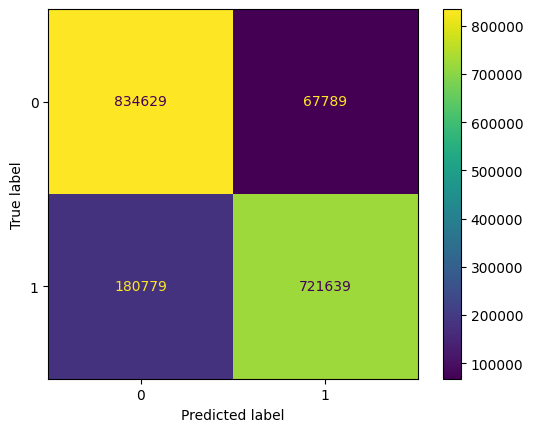

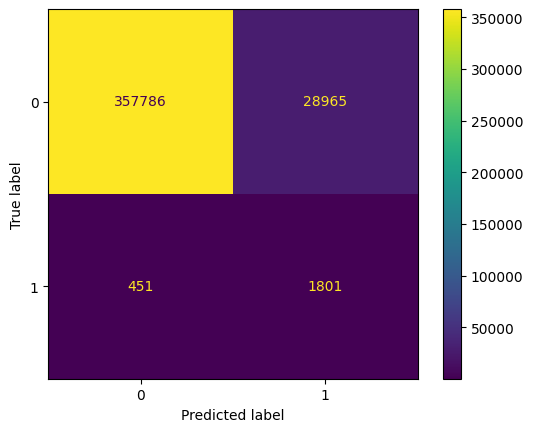

In [13]:
ml_model('LR')

Train f1:  1.0, 
        recall: 1.0,
        precision: 1.0
Test f1:  0.7684887459807074, 
        recall: 0.8490230905861457,
        precision: 0.7019089574155654
Train and Test confusion matrix:



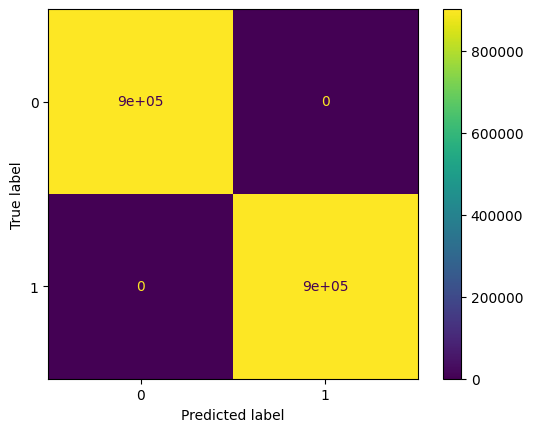

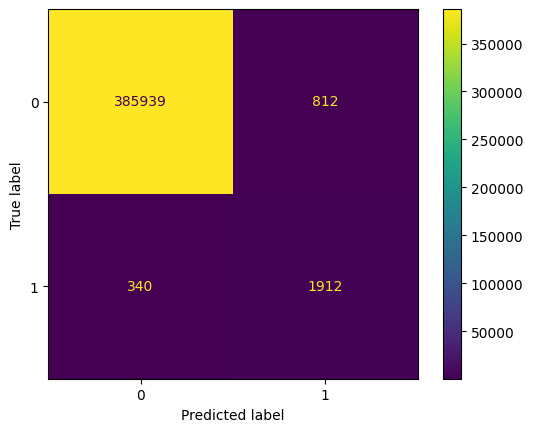

In [15]:
ml_model('DT')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.5s finished


Train f1:  1.0, 
        recall: 1.0,
        precision: 1.0
Test f1:  0.8457168825266985, 
        recall: 0.8263765541740675,
        precision: 0.8659841786877618
Train and Test confusion matrix:



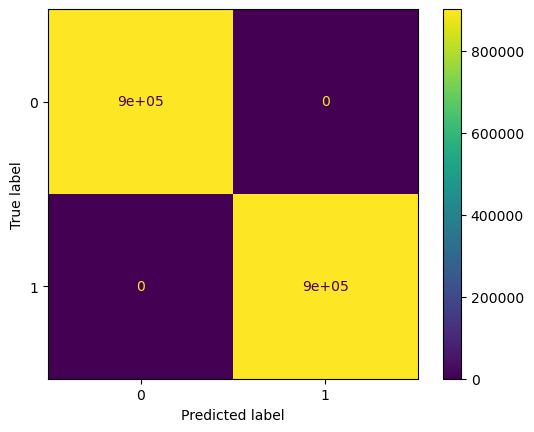

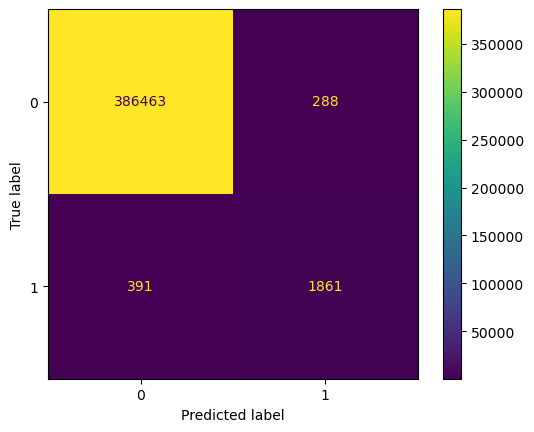

In [99]:
rf_model = ml_model('RF')

## ANN Classsifier With Embedding
* <font size=4>***Categorical features are label encoded for embedding. dimension of embedding vector = min(32, $cardinality^{0.5}$)***</font>
* <font size=4>***Recall = 0.732, Precision = 0.585 and f1  = 0.650***</font>

### Loading Data

In [10]:
data = pd.read_csv('preprocessed_dl.csv', index_col=0)
with open('embedding_dim.pkl', 'rb') as f:
    embedding_dim_map = pickle.load(f)
    f.close()
with open('cardinality.pkl', 'rb') as f:
    cardinality_map = pickle.load(f)
    f.close()
print(embedding_dim_map)
print(cardinality_map)

{'merchant': 27, 'street': 32, 'category': 4, 'city': 30, 'job': 23, 'zip': 32, 'gender': 2, 'hour': 5}
{'merchant': 693, 'street': 983, 'category': 14, 'city': 894, 'job': 494, 'zip': 970, 'gender': 2, 'hour': 24}


In [14]:
cat_features = embedding_dim_map.keys()
num_features = list()
for f in data.columns:
    if f not in cat_features and f != 'is_fraud':
        num_features.append(f)
print(num_features)

['amt', 'city_pop', 'merch_lat', 'merch_long', 'age']


In [16]:
X = data.drop(columns=['is_fraud'])
y = data['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=100, stratify=y)
print(f"% of positive in train data: {y_train[data['is_fraud']==1].shape[0]/y_train.shape[0]*100}")
print(f"% of positive in test data: {y_test[data['is_fraud']==1].shape[0]/y_test.shape[0]*100}")

% of positive in train data: 0.5788434588706052
% of positive in test data: 0.5789158438366799


In [17]:
# Train Data Oversampling
sm = SMOTE(random_state=100)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)
print(f"% of positive in train data: {y_train[y_train==1].shape[0]/y_train.shape[0]*100}")

(1804836, 13) (1804836,)
% of positive in train data: 50.0


In [40]:
embedding_dims = list()
cardinality = list()
for f in cat_features:
    embedding_dims.append(embedding_dim_map[f])
    cardinality.append(cardinality_map[f])
print(embedding_dims, cardinality)

[27, 32, 4, 30, 23, 32, 2, 5] [693, 983, 14, 894, 494, 970, 2, 24]


### Model Building

In [6]:
class CustomDataset(Dataset):
    def __init__(self, X_train, y_train, cat_features, num_features):
        self.X_cat = torch.tensor(X_train[cat_features].values).type(torch.long)
        self.X_num = torch.tensor(X_train[num_features].values).type(torch.float32)
        self.y = torch.tensor(y_train.values.reshape((-1,1))).type(torch.float32)
        self.n_samples = self.X_cat.shape[0]
    def __len__(self):
        # lenght of the data
        return self.n_samples
    def __getitem__(self, index):
        return (self.X_cat[index],self.X_num[index],self.y[index])
    

class ANNClassifier(nn.Module):
    def __init__(self, embedding_dims, cardinality, no_num_features):
        super(ANNClassifier, self).__init__()
        input_size = sum(embedding_dims) + no_num_features # input size
        self.embeddings = nn.ModuleList( # embedding layers
            [nn.Embedding(cardinality[i], embedding_dims[i]) for i in range(len(cardinality))]
        )
        self.no_cat_features = len(cardinality)
        self.l1 = nn.Linear(input_size,64) # 64 units
        self.l1_ac = nn.ReLU()
        self.l2 = nn.Linear(64, 32) # 32 Units
        self.l2_ac = nn.ReLU()
        self.l3 = nn.Linear(32, 1) # 
        self.l3_ac = nn.Sigmoid()
        
        
    def forward(self, x_cat, x_num):
        # calculate embedding, concatenate with numerical features
        embeddings = [self.embeddings[i](x_cat[:,i]) for i in range(self.no_cat_features)]
        embeddings = torch.cat(embeddings, dim=1)
        x = torch.cat((embeddings, x_num), dim=1)
        # forward pass
        out = self.l1(x)
        out = self.l1_ac(out)
        out = self.l2(out)
        out = self.l2_ac(out)
        out = self.l3(out)
        out = self.l3_ac(out)
        
        return out
    
    
def fit(X_train,y_train):
    device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    batch_size = 1024
    input_size = X_train.shape[1]
    lr = 0.01
    model = ANNClassifier(embedding_dims,cardinality,len(num_features))
    model.to(device_gpu)
    loss_fn = nn.BCELoss()
    # optimizer = torch.optim.SGD(model.parameters(),lr = lr)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    epochs = 3
    # get the data loader
    dataset = CustomDataset(X_train, y_train, cat_features, num_features)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    total_steps = len(dataloader)
    for i in range(epochs):
        for j, (X_cat, X_num, y) in enumerate(dataloader):
            # forward pass
            X_cat = X_cat.to(device_gpu)
            X_num = X_num.to(device_gpu)
            y = y.to(device_gpu)
            outputs = model(X_cat, X_num)
            loss = loss_fn(outputs, y)
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (j+1)%100 == 0:
                print(f"At epoch {i+1}, step {j}/{total_steps}, loss = {loss.item():0.3f}")
    return model

### Model Architecture

In [33]:
model = ANNClassifier(embedding_dims, cardinality, len(num_features))
print(model)

ANNClassifier(
  (embeddings): ModuleList(
    (0): Embedding(693, 27)
    (1): Embedding(983, 32)
    (2): Embedding(14, 4)
    (3): Embedding(894, 30)
    (4): Embedding(494, 23)
    (5): Embedding(970, 32)
    (6): Embedding(2, 2)
    (7): Embedding(24, 5)
  )
  (l1): Linear(in_features=160, out_features=64, bias=True)
  (l1_ac): ReLU()
  (l2): Linear(in_features=64, out_features=32, bias=True)
  (l2_ac): ReLU()
  (l3): Linear(in_features=32, out_features=1, bias=True)
  (l3_ac): Sigmoid()
)


### Model Training

In [36]:
model = fit(X_train, y_train)

At epoch 1, step 99/1763, loss = 0.203
At epoch 1, step 199/1763, loss = 0.150
At epoch 1, step 299/1763, loss = 0.123
At epoch 1, step 399/1763, loss = 0.068
At epoch 1, step 499/1763, loss = 0.057
At epoch 1, step 599/1763, loss = 0.055
At epoch 1, step 699/1763, loss = 0.030
At epoch 1, step 799/1763, loss = 0.042
At epoch 1, step 899/1763, loss = 0.046
At epoch 1, step 999/1763, loss = 0.024
At epoch 1, step 1099/1763, loss = 0.031
At epoch 1, step 1199/1763, loss = 0.031
At epoch 1, step 1299/1763, loss = 0.035
At epoch 1, step 1399/1763, loss = 0.027
At epoch 1, step 1499/1763, loss = 0.037
At epoch 1, step 1599/1763, loss = 0.022
At epoch 1, step 1699/1763, loss = 0.033
At epoch 2, step 99/1763, loss = 0.015
At epoch 2, step 199/1763, loss = 0.030
At epoch 2, step 299/1763, loss = 0.021
At epoch 2, step 399/1763, loss = 0.020
At epoch 2, step 499/1763, loss = 0.022
At epoch 2, step 599/1763, loss = 0.033
At epoch 2, step 699/1763, loss = 0.023
At epoch 2, step 799/1763, loss = 0

### Performance on Test Data

In [42]:
y_pred = model(torch.tensor(X_test[cat_features].values).type(torch.long).to('cuda')
               , torch.tensor(X_test[num_features].values).type(torch.float32).to('cuda'))
y_pred = y_pred.cpu().detach().numpy()
pred_fn = lambda x: 1 if x >= 0.5 else 0
pred_fn = np.vectorize(pred_fn)
y_pred_labels = pred_fn(y_pred)
cm_test = confusion_matrix(y_test, y_pred_labels.ravel())
f1_test = f1_score(y_test, y_pred_labels)
print(f'''Test f1:  {f1_test}, 
        recall: {cm_test[1,1]/(cm_test[1,0]+cm_test[1,1])},
        precision: {cm_test[1,1]/(cm_test[0,1]+cm_test[1,1])}''')

Test f1:  0.650374458021285, 
        recall: 0.7326820603907638,
        precision: 0.5846917080085046


In [44]:
cm_test

array([[385579,   1172],
       [   602,   1650]])

## ANN Classifier With Engineered Feature
* <font size=4>***Preprocessed data used to train ML model is used here to train ANN model***</font>
* <font size=4>***Recall=0.914, precision=0.212, f1 score=0.344***</font>
* <font size=4>***ANN based classifier suffers from lot of false positives, though rate of false negatives is low***</font>

### Model Building

In [78]:
class CustomDataset(Dataset):
    def __init__(self, X_train, y_train):
        self.X = torch.tensor(X_train).type(torch.float32)
        self.y = torch.tensor(y_train.reshape((-1,1))).type(torch.float32)
        self.n_samples = self.X.shape[0]
    def __len__(self):
        # lenght of the data
        return self.n_samples 
    def __getitem__(self, index):
        return (self.X[index],self.y[index])

class ANNClassifier2(nn.Module):
    def __init__(self, input_size):
        super(ANNClassifier2, self).__init__()
        self.l1 = nn.Linear(input_size,64) # 64 units
        self.l1_ac = nn.ReLU()
        self.l2 = nn.Linear(64, 32) # 32 Units
        self.l2_ac = nn.ReLU()
        self.l3 = nn.Linear(32, 1) 
        self.l3_ac = nn.Sigmoid()
        
    def forward(self, x):
        out = self.l1(x)
        out = self.l1_ac(out)
        out = self.l2(out)
        out = self.l2_ac(out)
        out = self.l3(out)
        out = self.l3_ac(out)
        
        return out
    
    
def fit(X_train,y_train):
    device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # device_cpu = torch.device('cpu')
    batch_size = 2000
    input_size = X_train.shape[1]
    lr = 0.01
    # hidden_size = 200
    # classes = 10
    # print(device_gpu)
    model = ANNClassifier2(input_size)
    model.to(device_gpu)
    loss_fn = nn.BCELoss()
    # loss_fn = WeightedLoss()
    # optimizer = torch.optim.SGD(model.parameters(),lr = lr)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    epochs = 10
    # get the data loader
    dataset = CustomDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    total_steps = len(dataloader)
    for i in range(epochs):
        for j, (X, y) in enumerate(dataloader):
            # forward pass
            X = X.to(device_gpu)
            y = y.to(device_gpu)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (j+1)%100 == 0:
                print(f"At epoch {i+1}, step {j}/{total_steps}, loss = {loss.item():0.3f}")
    return model

### Model Architecture

In [60]:
model = ANNClassifier2(13)
print(model)

ANNClassifier2(
  (l1): Linear(in_features=13, out_features=64, bias=True)
  (l1_ac): ReLU()
  (l2): Linear(in_features=64, out_features=32, bias=True)
  (l2_ac): ReLU()
  (l3): Linear(in_features=32, out_features=1, bias=True)
  (l3_ac): Sigmoid()
)


### Model Training

In [80]:
ann_model2 = fit(X_train, y_train)

At epoch 1, step 99/903, loss = 0.176
At epoch 1, step 199/903, loss = 0.132
At epoch 1, step 299/903, loss = 0.110
At epoch 1, step 399/903, loss = 0.095
At epoch 1, step 499/903, loss = 0.102
At epoch 1, step 599/903, loss = 0.093
At epoch 1, step 699/903, loss = 0.097
At epoch 1, step 799/903, loss = 0.102
At epoch 1, step 899/903, loss = 0.114
At epoch 2, step 99/903, loss = 0.087
At epoch 2, step 199/903, loss = 0.089
At epoch 2, step 299/903, loss = 0.102
At epoch 2, step 399/903, loss = 0.080
At epoch 2, step 499/903, loss = 0.079
At epoch 2, step 599/903, loss = 0.095
At epoch 2, step 699/903, loss = 0.078
At epoch 2, step 799/903, loss = 0.076
At epoch 2, step 899/903, loss = 0.066
At epoch 3, step 99/903, loss = 0.070
At epoch 3, step 199/903, loss = 0.059
At epoch 3, step 299/903, loss = 0.063
At epoch 3, step 399/903, loss = 0.057
At epoch 3, step 499/903, loss = 0.060
At epoch 3, step 599/903, loss = 0.074
At epoch 3, step 699/903, loss = 0.058
At epoch 3, step 799/903, lo

### Performnace with test data

In [88]:
def performance(X, y):
    y_pred = ann_model2(torch.tensor(X).type(torch.float32).to('cuda'))
    y_pred = y_pred.cpu().detach().numpy()
    pred_fn = lambda x: 1 if x >= 0.5 else 0
    pred_fn = np.vectorize(pred_fn)
    y_pred_labels = pred_fn(y_pred)
    cm_test = confusion_matrix(y, y_pred_labels.ravel())
    f1_test = f1_score(y, y_pred_labels)
    print(f'''Test f1:  {f1_test}, 
        recall: {cm_test[1,1]/(cm_test[1,0]+cm_test[1,1])},
        precision: {cm_test[1,1]/(cm_test[1,1]+cm_test[0,1])}''')
    print(cm_test)

In [90]:
performance(X_test, y_test)

Test f1:  0.3445160210825734, 
        recall: 0.9142984014209592,
        precision: 0.21224616018967116
[[379109   7642]
 [   193   2059]]


## Combine RF with ANN2
* <font size=4>***Here we combine outputs of RF and ANN. If recall is important then weightage of ANN will be higher, if precision is important weightage of RF will be higher***</font>
* <font size=4>***Result of equal weightage: recall=0.895, precision=0.478, f1=0.623***</font>

In [103]:
rf_pred = rf_model.predict_proba(X_test)[:,1]
ann_pred = ann_model2.to('cpu')(torch.tensor(X_test).type(torch.float32)).detach().numpy().flatten()
print(rf_pred.shape)
print(ann_pred.shape)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.5s finished


(389003,)
(389003,)


In [105]:
y_test_score = 0.5*rf_pred + 0.5*ann_pred
rule = np.vectorize(lambda x: 1 if x>= 0.5 else 0)
y_test_pred = rule(y_test_score)

In [109]:
cm_test = confusion_matrix(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
print(f'''Test f1:  {f1_test}, 
    recall: {cm_test[1,1]/(cm_test[1,0]+cm_test[1,1])},
    precision: {(cm_test[1,1])/(cm_test[0,1]+cm_test[1,1])}''')
print(cm_test)

Test f1:  0.6234730168548013, 
    recall: 0.8952042628774423,
    precision: 0.4782918149466192
[[384552   2199]
 [   236   2016]]
